✅ Scaled portfolio data loaded
  Ticker             Company  MarketCap  Revenues_M  Profits_M  ExpectedReturn
0    WMT             Walmart   0.150380    1.000000   0.157649        0.096455
1   AMZN              Amazon   0.555158    0.846178   0.311824        0.022164
2   AAPL               Apple   1.000000    0.444530   1.000000        0.092205
3    UNH  UnitedHealth Group   0.126420    0.420068   0.228668        0.211936
4   BRKA  Berkshire Hathaway   0.255971    0.405092   0.992019        0.540969
✅ QUBO problem created


C:\Users\japes\AppData\Local\Temp\ipykernel_14928\3502164107.py:58: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.qaoa.QAOA`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.QAOA``. See https://qisk.it/algo_migration for a migration guide.
  qaoa = QAOA(reps=1, optimizer=COBYLA(maxiter=200), quantum_instance=AerSimulator())



✅ QAOA optimized portfolio saved to: C:\Users\japes\OneDrive\Desktop\japesh\04_result\qaoa_solution.csv


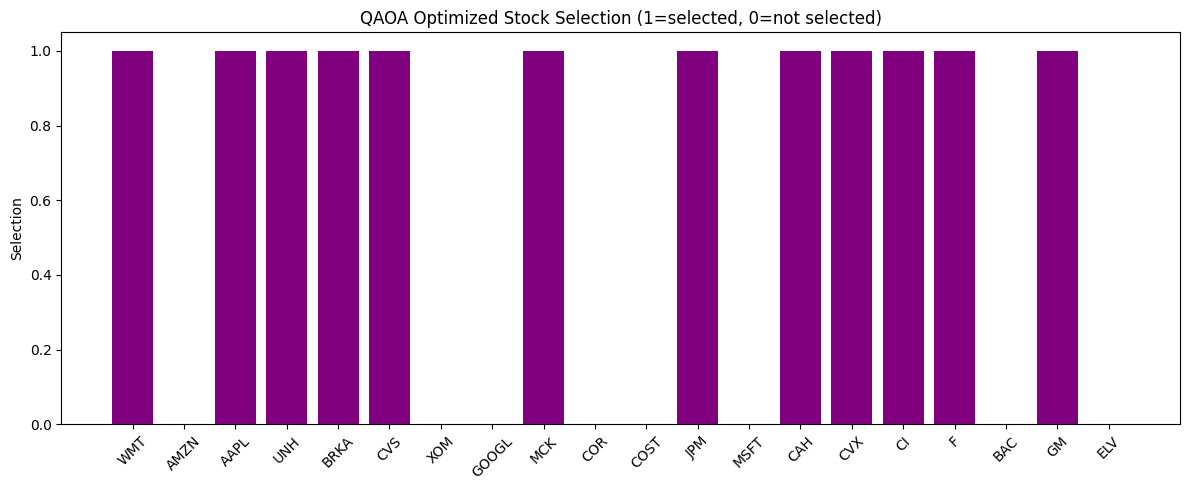

✅ Plot saved to: C:\Users\japes\OneDrive\Desktop\japesh\04_result\qaoa_selection_plot.png

--- Top Selected Stocks ---
   Ticker             Company  ExpectedReturn  MarketCap
0     WMT             Walmart        0.096455   0.150380
2    AAPL               Apple        0.092205   1.000000
3     UNH  UnitedHealth Group        0.211936   0.126420
4    BRKA  Berkshire Hathaway        0.540969   0.255971
5     CVS          CVS Health        0.603796   0.014230
8     MCK            McKesson        0.213588   0.014609
11    JPM      JPMorgan Chase        0.419209   0.162499
13    CAH     Cardinal Health        0.000000   0.000000
14    CVX             Chevron        0.366123   0.075352
15     CI               Cigna        0.257380   0.019968
16      F          Ford Motor        0.385820   0.009514
18     GM      General Motors        1.000000   0.009349


In [10]:
# ==============================
# 04_qaoa_runner.py
# QAOA Portfolio Optimization using Qiskit 0.24.1
# ==============================

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit_aer import AerSimulator

# ------------------------------
# 1️⃣ Load scaled portfolio data
# ------------------------------
feature_folder = r"C:\Users\japes\OneDrive\Desktop\japesh\02_feature"
scaled_csv = os.path.join(feature_folder, "scaled_portfolio_data.csv")
cov_file = os.path.join(feature_folder, "cov_matrix_scaled.npy")

df = pd.read_csv(scaled_csv)
cov_matrix = np.load(cov_file)

tickers = df["Ticker"].tolist()
expected_returns = df["ExpectedReturn"].values
N = len(tickers)

print("✅ Scaled portfolio data loaded")
print(df.head())

# ------------------------------
# 2️⃣ Build QUBO
# ------------------------------
risk_aversion = 0.5
qp = QuadraticProgram()

for t in tickers:
    qp.binary_var(name=t)

linear = {tickers[i]: -expected_returns[i] + risk_aversion * cov_matrix[i,i] for i in range(N)}
quadratic = {}
for i in range(N):
    for j in range(i+1, N):
        quadratic[(tickers[i], tickers[j])] = risk_aversion * cov_matrix[i,j]

qp.minimize(linear=linear, quadratic=quadratic)
print("✅ QUBO problem created")

# ------------------------------
# 3️⃣ Convert to QUBO and run QAOA
# ------------------------------
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)

qaoa = QAOA(reps=1, optimizer=COBYLA(maxiter=200), quantum_instance=AerSimulator())
result = qaoa.compute_minimum_eigenvalue(qubo.to_ising()[0])

# ------------------------------
# 4️⃣ Decode result manually
# ------------------------------
# result.eigenstate is now a dict: {'bitstring': probability}
eigen_dict = result.eigenstate
# Find bitstring with highest probability
most_likely_bitstring = max(eigen_dict, key=eigen_dict.get)

# Convert bitstring to list of integers
selection = [int(b) for b in most_likely_bitstring]
df["QAOA_Select"] = selection

# ------------------------------
# 5️⃣ Save results
# ------------------------------
results_folder = r"C:\Users\japes\OneDrive\Desktop\japesh\04_result"
os.makedirs(results_folder, exist_ok=True)

solution_csv = os.path.join(results_folder, "qaoa_solution.csv")
df.to_csv(solution_csv, index=False)
print(f"\n✅ QAOA optimized portfolio saved to: {solution_csv}")

# ------------------------------
# 6️⃣ Visualize selection
# ------------------------------
plt.figure(figsize=(12,5))
plt.bar(df["Ticker"], df["QAOA_Select"], color='purple')
plt.title("QAOA Optimized Stock Selection (1=selected, 0=not selected)")
plt.ylabel("Selection")
plt.xticks(rotation=45)
plt.tight_layout()
plot_file = os.path.join(results_folder, "qaoa_selection_plot.png")
plt.savefig(plot_file)
plt.show()
print(f"✅ Plot saved to: {plot_file}")

# ------------------------------
# 7️⃣ Display top selected stocks
# ------------------------------
print("\n--- Top Selected Stocks ---")
print(df[df["QAOA_Select"]==1][["Ticker","Company","ExpectedReturn","MarketCap"]])
